# Miniproyecto #3: Máquinas de soporte vectorial (SVM)


**Autores:**
*   Jorge Sebastián Arroyo Estrada CC. 1193482707
*   César Augusto Montoya Ocampo CC. 1036681523

**Tratamiento de Señales III**

**Facultad de Ingeniería**

**Universidad de Antioquia**

---

## Librerías

Importa diversas bibliotecas para el análisis y procesamiento de datos, así como para la implementación y evaluación de modelos de aprendizaje automático. Se utilizan bibliotecas estándar como `json`, `pickle` y `datetime` para manejo de archivos y tiempos. `matplotlib`, `numpy` y `pandas` se emplean para visualización y manipulación de datos. Las métricas y herramientas de `sklearn` como `accuracy_score`, `f1_score`, y `confusion_matrix` se usan para evaluar el rendimiento de modelos, mientras que `GridSearchCV` y `train_test_split` facilitan la optimización y la partición de los datos. Además, se importa un clasificador de máquinas de soporte vectorial (`SVC`) y un preprocesador (`StandardScaler`).

In [ ]:
import json
import pickle
from datetime import datetime, timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## Globales

Definir rutas para archivos de bases de datos, configurando parámetros globales para un modelo de ML. Establece la ruta base de las características (`DB_BASE_PATH`) y genera listas de nombres y rutas de archivos para cuatro bases de datos con resoluciones de 64x64 y 128x128, diferenciando entre características y PCA. También define la ruta para un archivo de etiquetas (`LABELS_PATH`) y crea un directorio para almacenar los resultados del modelo (`RESULTS_FOLDER`). Se configuran parámetros globales como el estado aleatorio (`RANDOM_STATE`), la validación cruzada (`K`), el estimador con el parámetro de búsqueda de la cuadrícula (`PARAM_GRID`), y las métricas de evaluación como `precision`, `accuracy`, `recall` y `f1_score`. La métrica principal para la optimización del modelo es la puntuación F1 ponderada (`f1_weighted`).

In [2]:
# Database files paths
DB_BASE_PATH = Path("../02_features/")
RESOLUTIONS = 2 * [64, 128]
DB_NAMES = [
    f"DB {RESOLUTIONS[i]}×{RESOLUTIONS[i]}{' PCA' if i >= 2 else ''}" for i in range(4)
]
DB_PATHS = [
    DB_BASE_PATH / f"{'features' if i < 2 else 'pca'}_{RESOLUTIONS[i]}.csv"
    for i in range(4)
]
DB_DICT = {name: path for name, path in zip(DB_NAMES, DB_PATHS)}

# Classes to labels mapping file path
LABELS_PATH = DB_BASE_PATH / "labels.csv"

# Results folder
RESULTS_FOLDER = Path("./svm_results/")
RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

In [3]:
# Global parameters
RANDOM_STATE = 15
K = 5
ESTIMATOR = SVC(random_state=RANDOM_STATE)
PARAM_GRID = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
}
SCORE_METRICS = {
    "accuracy": make_scorer(accuracy_score),
    "precision_weighted": make_scorer(precision_score, average="weighted"),
    "recall_weighted": make_scorer(recall_score, average="weighted"),
    "f1_weighted": make_scorer(f1_score, average="weighted"),
}
MAIN_SCORE_METRIC = list(SCORE_METRICS.keys())[-1]

## SVM

Este código define varias funciones para manejar el procesamiento de datos, entrenamiento de modelos y almacenamiento de resultados:

- `load_and_preprocess_data`: Carga un archivo CSV, separa las características y las etiquetas, y normaliza las características utilizando `StandardScaler`.
- `load_label_mapping`: Carga un archivo CSV con etiquetas de clases y devuelve un diccionario que mapea los números de clase a nombres legibles.
- `load_results`: Carga los resultados previamente guardados de un experimento, incluyendo el mejor modelo entrenado, métricas de entrenamiento, validación y prueba, y el tiempo de inferencia. Retorna `None` si no se encuentran los archivos o si ocurre un error.
- `save_results`: Guarda los resultados de un experimento en disco, incluyendo las métricas de evaluación, el tiempo de inferencia y el mejor modelo entrenado en formatos JSON y pickle.
- `grid_search_cv`: Realiza una búsqueda en cuadrícula para optimizar los hiperparámetros de un modelo de aprendizaje automático, utilizando validación cruzada y varias métricas de evaluación. Retorna el mejor modelo, las métricas de entrenamiento y validación promedio, y el tiempo de inferencia.
- `evaluate_model`: Evalúa el rendimiento de un modelo calculando métricas como precisión, recall, F1 y exactitud sobre las etiquetas verdaderas y predichas.

In [ ]:
def load_and_preprocess_data(path: Path) -> tuple[np.ndarray, pd.Series]:
    """
    Load data from a CSV file, separate features and labels,
    and apply standard scaling to features.

    Parameters:
        path (Path): Path to the CSV file

    Returns:
        Tuple[np.ndarray, pd.Series]: Scaled features and target labels
    """
    df = pd.read_csv(path)

    # Randomly shuffle the rows of the DataFrame
    df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Standarize features
    X_scaled = StandardScaler().fit_transform(X)
    return X_scaled, y


def load_label_mapping(label_path: Path) -> dict[int, str]:
    """
    Load label mappings from CSV, mapping class numbers to readable names.

    Parameters:
        label_path (Path): Path to the label CSV file

    Returns:
        Dict[int, str]: Dictionary mapping class numbers to readable labels
    """
    label_df = pd.read_csv(label_path)
    label_mapping = dict(zip(label_df["Class"], label_df["label"]))
    return label_mapping


def load_results(name: str) -> tuple[object, dict, dict, dict, timedelta] | None:
    """
    Loads previously saved results for a given experiment name from disk.

    This function retrieves train, validation, and test scores, the inference time,
    and the best model saved as part of a previous run. Results are expected to be
    stored in a predefined folder (`RESULTS_FOLDER`) and use a naming convention
    based on the provided `name`.

    Args:
        name (str): The identifier for the experiment, used to locate the stored files.

    Returns:
        tuple: A tuple containing:
            - best_estimator (object): The trained model loaded from a pickle file.
            - train_scores (dict): Training evaluation metrics.
            - validation_scores (dict): Validation evaluation metrics.
            - test_scores (dict): Test evaluation metrics.
            - inference_time (timedelta): The time taken for inference during the experiment.
        Returns `None` if the files are missing or there is an error in loading.

    Raises:
        OSError: If any of the required files cannot be found or opened.
    """
    try:
        # Load scores
        with open(RESULTS_FOLDER / f"{name}_train_results.json", "r") as f:
            train_scores = json.load(f)
        with open(RESULTS_FOLDER / f"{name}_validation_results.json", "r") as f:
            validation_scores = json.load(f)
        with open(RESULTS_FOLDER / f"{name}_test_results.json", "r") as f:
            test_scores = json.load(f)

        # Load inference time
        with open(RESULTS_FOLDER / f"{name}_inference_time.txt", "r") as f:
            time_str = f.read().strip()
            time_obj = datetime.strptime(time_str, "%H:%M:%S.%f")
            inference_time = timedelta(
                hours=time_obj.hour,
                minutes=time_obj.minute,
                seconds=time_obj.second,
                microseconds=time_obj.microsecond,
            )

        # Load the best estimator using pickle
        with open(RESULTS_FOLDER / f"{name}_best_estimator.pkl", "rb") as f:
            best_estimator = pickle.load(f)

        return (
            best_estimator,
            train_scores,
            validation_scores,
            test_scores,
            inference_time,
        )

    except OSError:
        return None


def save_results(
    best_estimator: object,
    train_scores: dict,
    validation_scores: dict,
    test_scores: dict,
    inference_time: timedelta,
    name: str,
) -> None:
    """
    Saves experiment results to disk.

    This function stores train, validation, and test evaluation metrics as JSON files,
    inference time as a text file, and the best-trained model using pickle. The files
    are named based on the provided experiment name and stored in the predefined
    `RESULTS_FOLDER`.

    Args:
        best_estimator (object): The trained model to be saved.
        train_scores (dict): Training evaluation metrics.
        validation_scores (dict): Validation evaluation metrics.
        test_scores (dict): Test evaluation metrics.
        inference_time (timedelta): The time taken for inference during the experiment.
        name (str): The identifier for the experiment, used to name the stored files.

    Returns:
        None

    Raises:
        OSError: If there is an error in writing any of the files.
    """
    # Save metrics to JSON files
    with open(RESULTS_FOLDER / f"{name}_train_results.json", "w") as f:
        json.dump(train_scores, f)
    with open(RESULTS_FOLDER / f"{name}_validation_results.json", "w") as f:
        json.dump(validation_scores, f)
    with open(RESULTS_FOLDER / f"{name}_test_results.json", "w") as f:
        json.dump(test_scores, f)

    # Save inference time
    with open(RESULTS_FOLDER / f"{name}_inference_time.txt", "w") as f:
        f.write(f"{inference_time}")

    # Save the best model using pickle
    with open(RESULTS_FOLDER / f"{name}_best_estimator.pkl", "wb") as f:
        pickle.dump(best_estimator, f)


def grid_search_cv(X_train: np.ndarray, y_train: np.ndarray):
    """
    Performs a grid search over hyperparameters to find the best model and evaluates its performance.

    This function uses GridSearchCV to train a model on the provided training data (`X_train` and `y_train`)
    with a specified estimator, parameter grid, and scoring metrics. It returns the best trained model,
    average train and validation scores across cross-validation folds for each metric, and the total inference time.

    Args:
        X_train: The feature matrix for training data.
        y_train: The target labels for training data.

    Returns:
        tuple: A tuple containing:
            - best_estimator: The model trained with the best combination of hyperparameters.
            - train_scores (dict): A dictionary mapping each metric to its average score on the training set.
            - validation_scores (dict): A dictionary mapping each metric to its average score on the validation set.
            - inference_time (timedelta): The total time taken to perform the grid search.

    Note:
        The function relies on global variables for:
        - `ESTIMATOR`: The machine learning model to optimize.
        - `PARAM_GRID`: The grid of hyperparameters for the search.
        - `K`: The number of cross-validation folds.
        - `SCORE_METRICS`: The dictionary of scoring metrics.
        - `MAIN_SCORE_METRIC`: The primary metric for refitting during the search.

    Raises:
        ValueError: If `X_train` or `y_train` do not match the expected dimensions for the estimator.
    """
    # Perform grid search
    grid_search = GridSearchCV(
        ESTIMATOR,
        PARAM_GRID,
        cv=K,
        scoring=SCORE_METRICS,
        refit=MAIN_SCORE_METRIC,
        return_train_score=True,
        verbose=1,
    )

    start_time = datetime.now()
    grid_search.fit(X_train, y_train)
    end_time = datetime.now()

    inference_time = end_time - start_time

    # Extract best estimator and cross-validation results
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_

    # Extract average train and validation scores for each metric
    train_scores = {
        metric: cv_results[f"mean_train_{metric}"].mean()
        for metric in SCORE_METRICS.keys()
    }
    validation_scores = {
        metric: cv_results[f"mean_test_{metric}"].mean()
        for metric in SCORE_METRICS.keys()
    }

    return best_estimator, train_scores, validation_scores, inference_time


def evaluate_model(y_true: pd.Series, y_pred: np.ndarray) -> dict[str, float]:
    """
    Evaluate the model's performance using accuracy, precision, recall, and F1 score.

    Args:
        y_true (pd.Series): True labels.
        y_pred (np.ndarray): Predicted labels.

    Returns:
        dict[str, float]: A dictionary containing the evaluation metrics.
    """
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted"),
        "f1_score": f1_score(y_true, y_pred, average="weighted"),
    }
    return metrics

Funciones misceláneas para mostrar los resultados en pantalla de manera ordenada:
- `print_results`: Muestra de forma estructurada las métricas de evaluación del modelo para los conjuntos de entrenamiento, validación y prueba, formateándolas como porcentajes. También imprime el tiempo total de inferencia.
- `plot_metrics`: Genera un gráfico de barras que representa las métricas de evaluación del modelo en porcentajes, con el objetivo de visualizar el desempeño de manera clara y comprensible.
- `plot_confusion_matrix`: Crea y visualiza una matriz de confusión basada en las etiquetas reales y predichas, permitiendo identificar patrones de errores en las predicciones del modelo.

In [10]:
def print_results(
    train_metrics: dict[str, float],
    val_metrics: dict[str, float],
    test_metrics: dict[str, float],
    inference_time: timedelta,
) -> None:
    """
    Print evaluation metrics and inference time in a structured and readable format.

    Args:
        train_metrics (dict[str, float]): Metrics for the training set,
                                          where keys are metric names and values are their scores.
        val_metrics (dict[str, float]): Metrics for the validation set,
                                        where keys are metric names and values are their scores.
        test_metrics (dict[str, float]): Metrics for the test set,
                                         where keys are metric names and values are their scores.
        inference_time (timedelta): Total time taken for inference.

    Returns:
        None
    """
    # Print metrics for the training set
    print("\nTrain Set Evaluation Metrics:")
    for metric, value in train_metrics.items():
        # Replace underscores with spaces and capitalize the metric name for better readability
        print(f"  {metric.replace('_', ' ').capitalize()}: {100 * value:.4f}%")

    # Print metrics for the validation set
    print("\nValidation Set Evaluation Metrics:")
    for metric, value in val_metrics.items():
        print(f"  {metric.replace('_', ' ').capitalize()}: {100 * value:.4f}%")

    # Print metrics for the test set
    print("\nTest Set Evaluation Metrics:")
    for metric, value in test_metrics.items():
        print(f"  {metric.replace('_', ' ').capitalize()}: {100 * value:.4f}%")

    # Print the total inference time
    print("\nInference time:", inference_time)


def plot_metrics(metrics: dict[str, float], name: str) -> None:
    """
    Plot the model evaluation metrics as a bar chart.

    Args:
        metrics (dict[str, float]): A dictionary containing evaluation metrics.
        name (str): Name for the plot.

    Returns:
        None
    """
    plt.figure(figsize=(8, 4))

    for x, y in metrics.items():
        y_ = 100 * y
        plt.bar(x, y_, width=0.5)

    plt.title(f"Model Evaluation Metrics for {name}")
    plt.ylabel("Score in percentage")
    plt.ylim(0, 100)
    plt.show()
    plt.savefig(RESULTS_FOLDER / f"metrics_{name}.png")
    plt.close()


def plot_confusion_matrix(
    y_true: pd.Series, y_pred: np.ndarray, name: str, label_mapping: dict[int, str]
) -> None:
    """
    Plot the confusion matrix for the model's predictions.

    Args:
        y_true (pd.Series): True labels.
        y_pred (np.ndarray): Predicted labels.
        name (str): Name of the plot.
        label_mapping (dict[int, str]): A dictionary mapping class numbers to class names.

    Returns:
        None
    """
    cm = confusion_matrix(y_true, y_pred)
    labels = [label_mapping[i] for i in sorted(label_mapping.keys())]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()
    plt.savefig(RESULTS_FOLDER / f"cm_{name}.png")
    plt.close()

El código principal que carga y preprocesa los datos desde un archivo CSV, estandariza las características y obtiene un mapeo de etiquetas (1). Luego divide los datos en conjuntos de entrenamiento y prueba, reservando un 20% para este último (2). Intenta cargar resultados previos para evitar cálculos redundantes (3). Si no existen, realiza una búsqueda de hiperparámetros mediante validación cruzada para encontrar el mejor modelo (4). Posteriormente, evalúa el modelo en el conjunto de prueba, calcula métricas clave, imprime los resultados e informa sobre el tiempo de inferencia (5). Si los resultados son nuevos, los guarda y genera visualizaciones como gráficos de métricas y matrices de confusión (6). Finalmente, retorna las métricas calculadas para entrenamiento, validación y prueba (7).

In [11]:
def main(
    name: str, db_path: Path
) -> tuple[dict[str, float], dict[str, float], dict[str, float]]:
    """
    Main function to load data, perform SVM classification with grid search, cross-validate the model, and evaluate it.

    Args:
        name (str): Name of the database used.
        db_path (Path): Path to the CSV file containing the data.

    Returns:
        None
    """
    print("================================================")
    # Load, standarize data and load class mapping
    X, y = load_and_preprocess_data(db_path)
    label_mapping = load_label_mapping(LABELS_PATH)

    # Partition data in training and test splits
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE
    )

    # Flag to know if data was already read from files
    FROM_FILES = False

    # Try to load previous results
    print(f"Trying to read previous results for {name}")
    load_result = load_results(name)
    FROM_FILES = load_result is not None

    if FROM_FILES:
        best_estimator, train_scores, validation_scores, test_scores, inference_time = (
            load_result
        )
    else:
        print(f"Were not able to read previous results, computing new ones for {name}")

        # Perform Grid Search with Cross-Validation
        best_estimator, train_scores, validation_scores, inference_time = (
            grid_search_cv(X_train, y_train)
        )

    # Predict on the test set using the best model
    y_pred = best_estimator.predict(X_test)
    test_scores = evaluate_model(y_test, y_pred)
    print_results(train_scores, validation_scores, test_scores, inference_time)
    print("================================================")

    # If not loaded from files save the calculated results
    if not FROM_FILES:
        save_results(
            best_estimator,
            train_scores,
            validation_scores,
            test_scores,
            inference_time,
            name,
        )

    # Plot metrics and confusion matrix
    plot_metrics(test_scores, name)
    plot_confusion_matrix(y_test, y_pred, name, label_mapping)

    return train_scores, validation_scores, test_scores

## Aplicar SVM

Ejecución de todo el código para cada una de las bases de datos disponibles, para ambas resoluciones y cuando se empleó PCA o no para la reducción de dimensionalidad

Trying to read previous results for DB 64×64
Were not able to read previous results, computing new ones for DB 64×64
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Train Set Evaluation Metrics:
  Accuracy: 97.4498%
  Precision weighted: 97.5577%
  Recall weighted: 97.4498%
  F1 weighted: 97.4423%

Validation Set Evaluation Metrics:
  Accuracy: 95.8078%
  Precision weighted: 95.9775%
  Recall weighted: 95.8078%
  F1 weighted: 95.7879%

Test Set Evaluation Metrics:
  Accuracy: 99.1778%
  Precision: 99.1851%
  Recall: 99.1778%
  F1 score: 99.1770%

Inference time: 0:07:12.992126


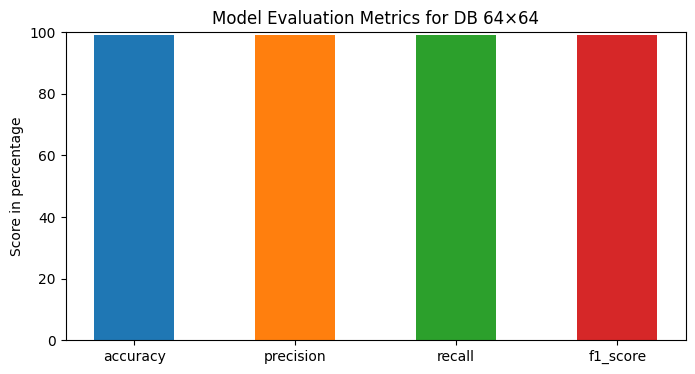

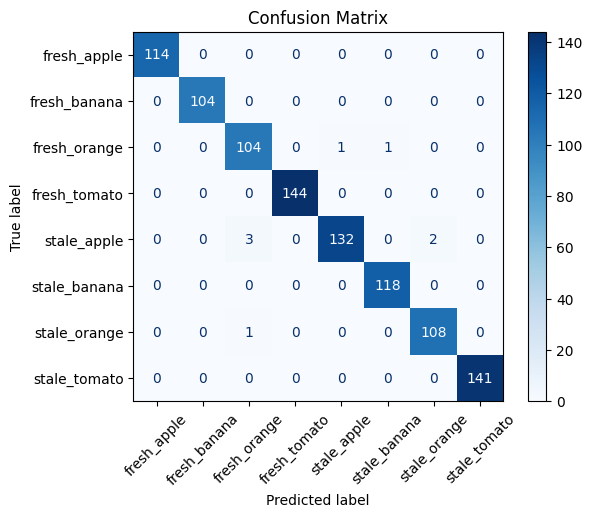

Trying to read previous results for DB 128×128
Were not able to read previous results, computing new ones for DB 128×128
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Train Set Evaluation Metrics:
  Accuracy: 96.0727%
  Precision weighted: 96.4468%
  Recall weighted: 96.0727%
  F1 weighted: 96.0443%

Validation Set Evaluation Metrics:
  Accuracy: 92.3778%
  Precision weighted: 92.8570%
  Recall weighted: 92.3778%
  F1 weighted: 92.3358%

Test Set Evaluation Metrics:
  Accuracy: 97.5334%
  Precision: 97.5511%
  Recall: 97.5334%
  F1 score: 97.5350%

Inference time: 0:37:25.126880


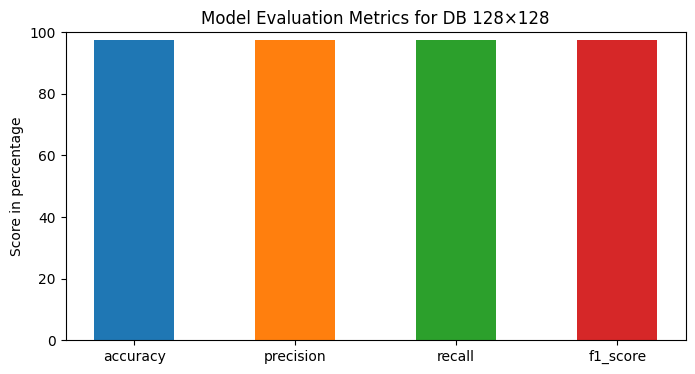

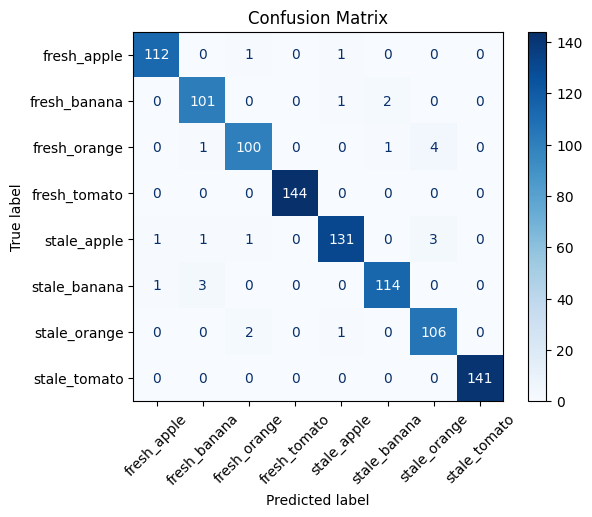

Trying to read previous results for DB 64×64 PCA
Were not able to read previous results, computing new ones for DB 64×64 PCA
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Train Set Evaluation Metrics:
  Accuracy: 92.3362%
  Precision weighted: 92.5693%
  Recall weighted: 92.3362%
  F1 weighted: 92.3548%

Validation Set Evaluation Metrics:
  Accuracy: 92.1269%
  Precision weighted: 92.4289%
  Recall weighted: 92.1269%
  F1 weighted: 92.1490%

Test Set Evaluation Metrics:
  Accuracy: 99.6917%
  Precision: 99.6983%
  Recall: 99.6917%
  F1 score: 99.6914%

Inference time: 0:00:41.170416


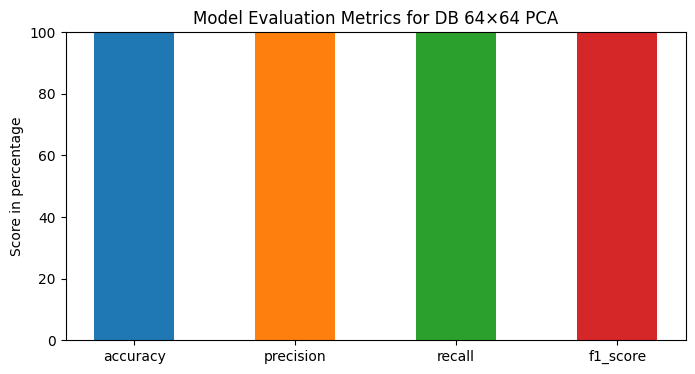

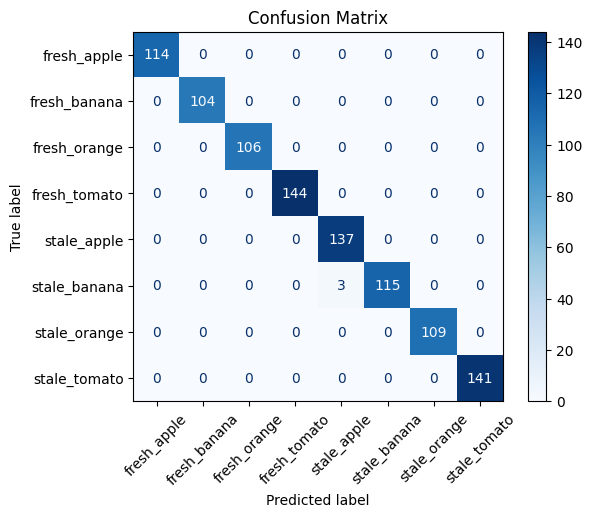

Trying to read previous results for DB 128×128 PCA
Were not able to read previous results, computing new ones for DB 128×128 PCA
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Train Set Evaluation Metrics:
  Accuracy: 92.9383%
  Precision weighted: 93.2867%
  Recall weighted: 92.9383%
  F1 weighted: 93.0267%

Validation Set Evaluation Metrics:
  Accuracy: 92.7160%
  Precision weighted: 93.1170%
  Recall weighted: 92.7160%
  F1 weighted: 92.8033%

Test Set Evaluation Metrics:
  Accuracy: 99.8972%
  Precision: 99.8982%
  Recall: 99.8972%
  F1 score: 99.8972%

Inference time: 0:00:46.446877


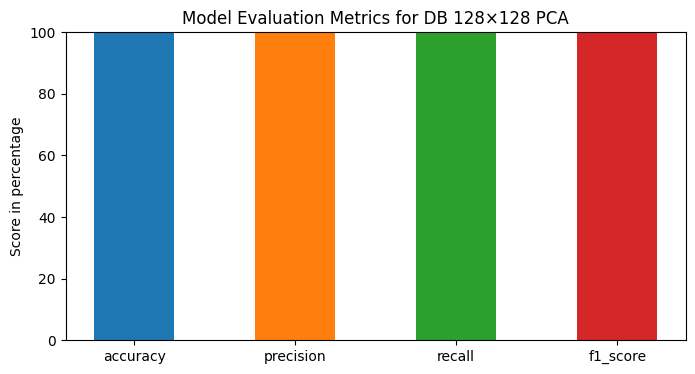

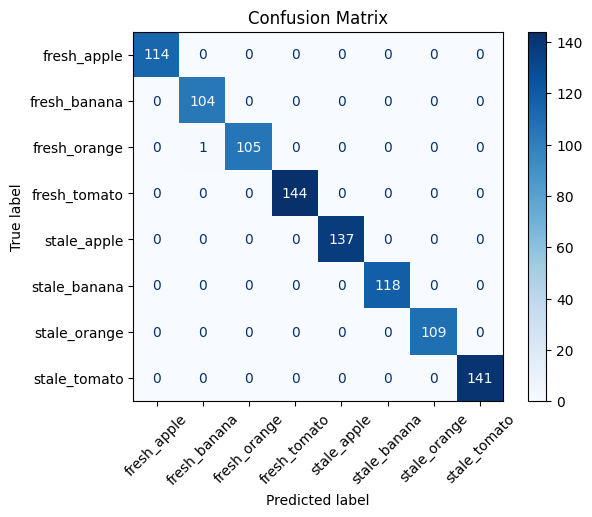

In [12]:
test_scores = {}
for name, path in DB_DICT.items():
    _, _, test_score = main(name, path)
    test_scores[name] = test_score

Graficar todas las métricas de prueba para cada una de las bases de datos, para así poder ver gráficamente cuál de las bases de datos nos entregó un mejor resultado.

In [8]:
def plot_grouped_metrics(metrics_dict: dict[str, dict[str, float]]) -> None:
    """
    Plots the evaluation metrics of multiple databases in a grouped bar plot.

    Args:
        metrics_dict (dict[str, dict[str, float]]):
            A dictionary where the keys are database names and the values are dictionaries of metrics.

    Returns:
        None
    """
    # Extract database names and metric names
    db_names = list(metrics_dict.keys())
    metric_names = list(next(iter(metrics_dict.values())).keys())

    # Create data for plotting
    n_dbs = len(db_names)
    n_metrics = len(metric_names)
    width = 0.1  # Width of each bar

    # Define the x positions for the groups of bars
    x = np.arange(n_dbs)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each metric for each database
    for i, metric in enumerate(metric_names):
        values = [
            metrics_dict[db][metric] * 100 for db in db_names
        ]  # Convert to percentage
        ax.bar(x + i * width, values, width, label=metric.capitalize())

    # Customize the plot
    ax.set_xlabel("Databases")
    ax.set_ylabel("Score in Percentage")
    ax.set_title("Comparison of Evaluation Metrics Across Databases")
    ax.set_xticks(x + width * (n_metrics - 1) / 2)
    ax.set_xticklabels(db_names)
    ax.legend(title="Metrics", loc="lower center")
    plt.ylim(95, 100)

    plt.show()

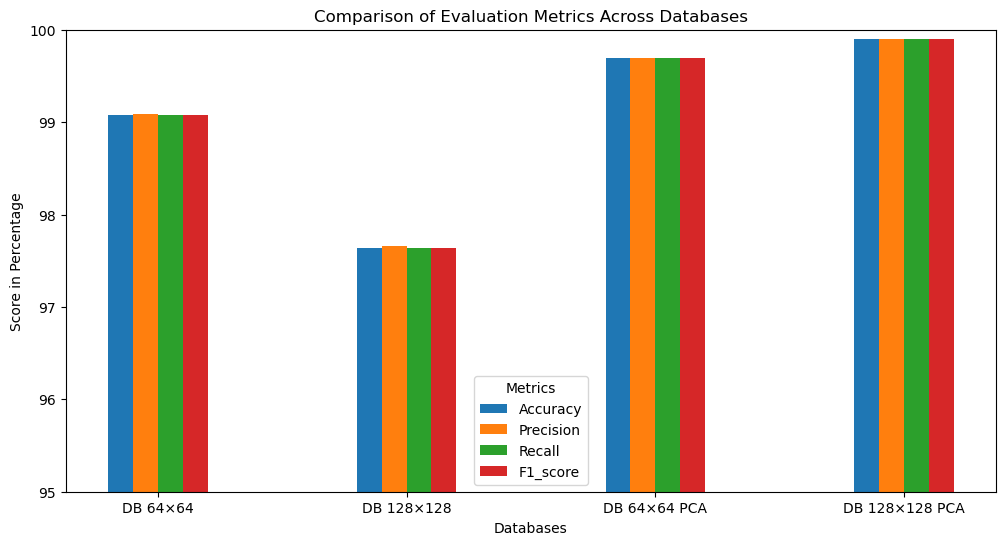

In [9]:
plot_grouped_metrics(test_scores)